In [ ]:
!pip install kaggle

In [ ]:
!pip install retina-face

In [ ]:
!pip install pyTelegramBotAPI

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -qq utkface-new.zip

In [46]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import telebot
from imutils.face_utils import FaceAligner
import imutils
from retinaface import RetinaFace
import dlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split

In [9]:
epochs = 12
width = height = 224

Get data

In [10]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [11]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[255, 251, 248], [255, 251, 248], [253, 252,...",1
1,"[[[198, 184, 173], [196, 182, 171], [194, 180,...",65
2,"[[[225, 208, 198], [228, 211, 201], [231, 214,...",2
3,"[[[45, 26, 28], [45, 26, 28], [44, 25, 27], [4...",3
4,"[[[25, 16, 7], [23, 14, 5], [21, 12, 3], [21, ...",46


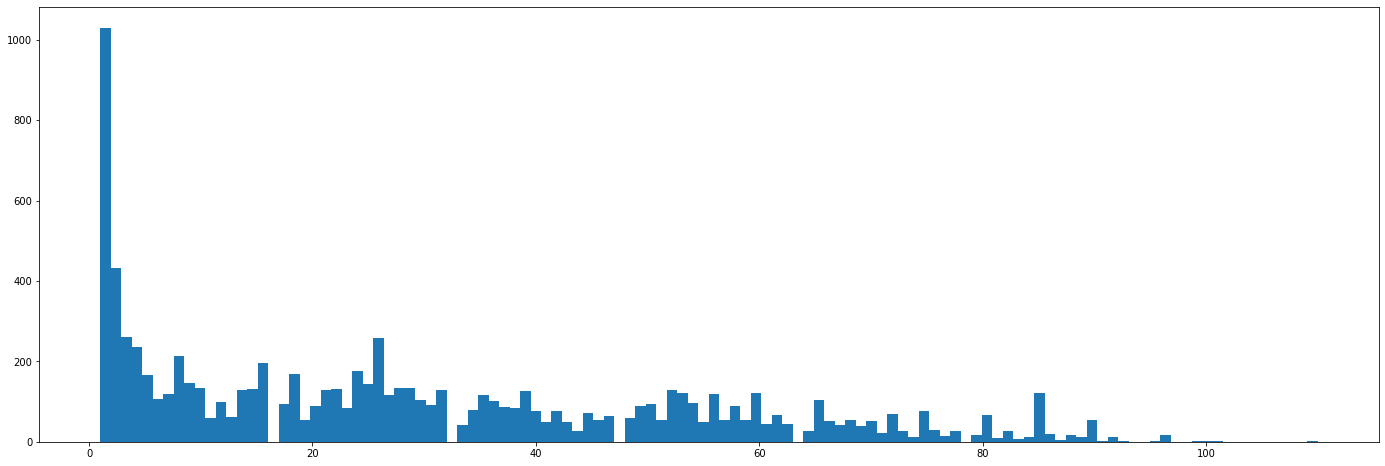

In [13]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 116)
plt.show()

Data normalize

In [14]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

In [15]:
df = df[df['Ages'] < 90]

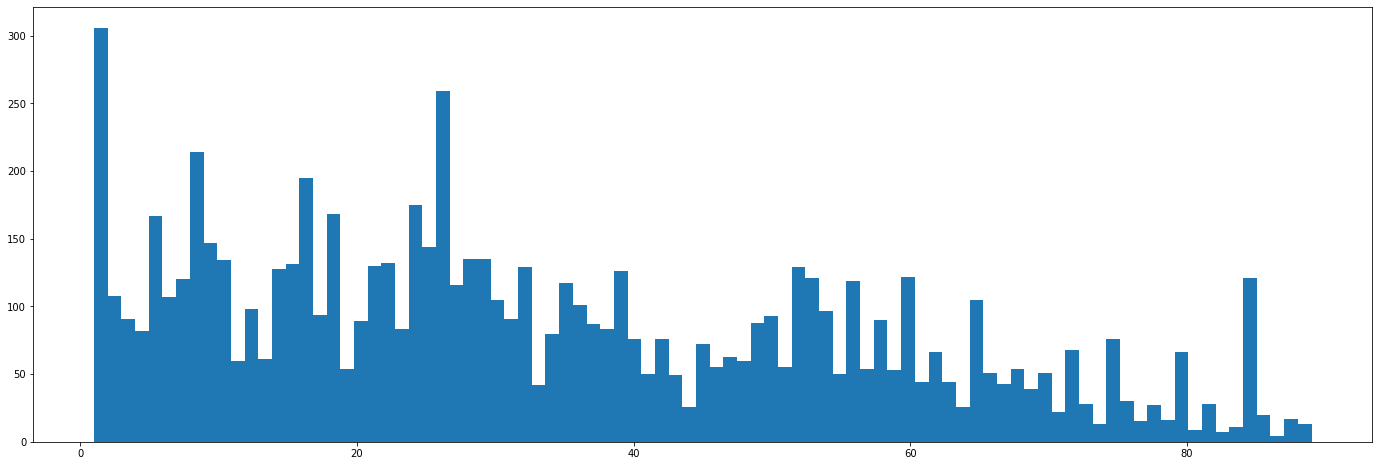

In [ ]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [16]:
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
X.shape

(7536, 224, 224, 3)

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

Train

In [20]:
data_generator = ImageDataGenerator(
                                  rescale = 1./ 255,
                                  horizontal_flip = True
                                  )

train_data = data_generator.flow(X_train,
                                 Y_train,
                                 batch_size= 32)

val_data = data_generator.flow(X_val,
                               Y_val,
                               batch_size= 32)

In [21]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
    )

9420800/9406464 [==============================] - 0s 0us/step


In [22]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [23]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(1, activation='relu')                          
])

In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr= 0.001),
              loss = tf.keras.losses.mean_squared_error)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
model.fit(train_data,
          validation_data = val_data,
          epochs = 10
)

Epoch 1/10
189/189 [==============================] - 57s 115ms/step - loss: 350.0790 - val_loss: 1861.4469
Epoch 2/10
189/189 [==============================] - 20s 106ms/step - loss: 160.6649 - val_loss: 790.3519
Epoch 3/10
189/189 [==============================] - 20s 107ms/step - loss: 135.3992 - val_loss: 454.6101
Epoch 4/10
189/189 [==============================] - 20s 107ms/step - loss: 121.4576 - val_loss: 240.4559
Epoch 5/10
189/189 [==============================] - 20s 107ms/step - loss: 113.5096 - val_loss: 443.7121
Epoch 6/10
189/189 [==============================] - 20s 107ms/step - loss: 102.9016 - val_loss: 341.1112
Epoch 7/10
189/189 [==============================] - 20s 107ms/step - loss: 95.9859 - val_loss: 295.5558
Epoch 8/10
189/189 [==============================] - 20s 106ms/step - loss: 89.6712 - val_loss: 261.5619
Epoch 9/10
189/189 [==============================] - 20s 107ms/step - loss: 84.0988 - val_loss: 220.7968
Epoch 10/10
189/189 [==================

Save model

In [54]:
model.save('/content/drive/MyDrive/age_model.h5')

Infrance

In [ ]:
def process_and_predict(image_path):
  faces = RetinaFace.extract_faces(image_path)

bot = telebot.TeleBot("_____________YOUR_TOKEN_______________")


@bot.message_handler(commands=['start'])
def say_hello(messages):
    bot.send_message(messages.chat.id, f'Wellcome Dear {messages.from_user.first_name}🌹')
    bot.send_message(messages.chat.id, f'Give me a photo of a person so I can estimate him\her age for you😉')

@bot.message_handler(content_types=['photo'])
def photo(message):
    file_info = bot.get_file(message.photo[-1].file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    src = file_info.file_path
    with open("/content/" + src, 'wb') as new_file:
        new_file.write(downloaded_file)

    bot.send_message(message.chat.id, 'Processing...\nPlease Wait')

    face = RetinaFace.extract_faces(img_path = "/content/" + src, align = True)
    if len(face) > 0:
        face = cv2.cvtColor(face[0], cv2.COLOR_BGR2RGB)
        cv2.imwrite("/content/" + src, face)
        image = cv2.imread("/content/" + src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (width, height))
        image = image/255
        image = image.reshape(1, width, height, 3)
        pred = model.predict([image])

        res = pred[0]
        bot.reply_to(message, "%.1f" % res)
    else:
        bot.send_message(message.chat.id, 'No Face')


bot.polling()